As it is mentioned in the documentation, the returns of the BERT model are (last_hidden_state, pooler_output, hidden_states[optional], attentions[optional])

output[0] is therefore the last hidden state and output[1] is the pooler output.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.4 MB/s eta 0:00:00


In [2]:
import torch
import tqdm
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer, AutoModel,BertModel
import pandas as pd
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
import matplotlib.pyplot as plt
import random


In [3]:
modell = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
!git clone https://github.com/dml-qom/FarsTail.git

Cloning into 'FarsTail'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 125 (delta 19), reused 18 (delta 18), pack-reused 104
Receiving objects: 100% (125/125), 43.86 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [7]:
train_df = pd.read_csv('/content/FarsTail/data/Train-word.csv', sep='\t')
val_df = pd.read_csv('/content/FarsTail/data/Val-word.csv', sep='\t')
test_df = pd.read_csv('/content/FarsTail/data/Test-word.csv', sep='\t')

In [8]:
test_df

,premise,hypothesis,label,hard(hypothesis),hard(overlap)
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,c,0,1
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,n,1,0
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,e,0,0
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,c,1,1
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,n,1,0
...,...,...,...,...,...
1559,دریای خَزَر یا دریای مازَندَران یا (با رواج کم...,در حاشیه ی دریای خزر کشور آذربایجان وجود ندارد.,c,0,1
1560,دریای خَزَر یا دریای مازَندَران یا (با رواج کم...,جمهوری آذربایجان به ترکی آذربایجانی بزرگترین ک...,n,0,1
1561,اولین چاپ مطالب به زبان فارسی در روزنامه‌های ه...,اولین روزنامه فارسی در هند انتشار یافت.,e,1,0
1562,اولین چاپ مطالب به زبان فارسی در روزنامه‌های ه...,ایران نخستین روزنامه فارسی را چاپ کرد.,c,1,0


In [9]:
val_df.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [10]:
def save_checkpoint(state, filename):
    model_save_name = filename
    path = F"/content/drive/My Drive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model):
    print("=> Loading checkpoint")
    #model.load_state_dict(checkpoint["state_dict"])
    test_list = checkpoint["test_acc_list"]
    return test_list

In [11]:
class FarsTailDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df):
    self.label_dict = {'e': 0, 'c': 1, 'n': 2}

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased") # Using a pre-trained BERT tokenizer to encode sentences
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)
    self.test_data = self.load_data(self.test_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['premise'].to_list()
    hypothesis_list = df['hypothesis'].to_list()
    label_list = df['label'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])

    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )
  

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    test_loader = DataLoader(
      self.test_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader, test_loader
  


## task1

In [12]:
import torch.nn as nn

class BERTNLIModel(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.bert = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
        embedding_dim = self.bert.config.to_dict()['hidden_size']

        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(embedding_dim, 256)
        self.act_func = nn.ReLU()
        self.fc2 = nn.Linear(256, 3)

    def forward(self, sequence, attn_mask, token_type):
          
        embedded = self.bert(input_ids = sequence, attention_mask = attn_mask, token_type_ids= token_type)
        # print("embedded :",embedded)
        # print("embedded['last_hidden_state']:",embedded['last_hidden_state'])
        t_e = self.transformer_encoder( self.dropout(embedded['last_hidden_state']))
        out = self.act_func(self.fc1(torch.mean(t_e, dim=1)))
        out = self.fc2(out)

        return out

model = BERTNLIModel().to(device)

for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
  model(pair_token_ids, mask_ids, seg_ids)
  break


model.bert.encoder.layer[0]

In [13]:
def train(model, iterator, optimizer, criterion):
    #print(iterator)
    
    epoch_loss = 0
    epoch_acc = 0
    pred = []
    labels = []
    
    model.train()
    
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(iterator):

        optimizer.zero_grad() # clear gradients first
        torch.cuda.empty_cache() # releases all unoccupied cached memory 
         

        sequence = pair_token_ids.to(device)
        attn_mask = mask_ids.to(device)
        token_type = seg_ids.to(device)
        label = y.to(device)


       
        predictions = model(sequence, attn_mask, token_type)
        max_preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
        # print("max_preds:",max_preds)
        correct = (max_preds==label).float()
        acc = correct.sum() / len(label)

        # print("max_preds :",max_preds )
        
        pred.extend(max_preds.tolist())
        labels.extend(label.tolist())
       
        
        loss = criterion(predictions, label)
        # print("loss :",loss )
        
      
        loss.backward()
        optimizer.step()
        

        epoch_loss += loss.item()
        epoch_acc += acc.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator), pred, labels

In [14]:
def evaluate(model, iterator, optimizer, criterion, flag_test_f):
    #print(iterator)
    epoch_loss = 0
    epoch_acc = 0
    pred = []
    labels = []

    model.eval()
    
    with torch.no_grad():
    
        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(iterator):
            #print(batch)

            sequence = pair_token_ids.to(device)
            attn_mask = mask_ids.to(device)
            token_type = seg_ids.to(device)
            label = y.to(device)

            predictions = model(sequence, attn_mask, token_type)
            max_preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
            correct = (max_preds==label).float()
            acc = correct.sum() / len(label)

            pred.extend(max_preds.tolist())
            labels.extend(label.tolist())

            loss = criterion(predictions, label)
           
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        if flag_test_f == True:

          print(f"F1_score: {f1_score(pred,labels, average='weighted') :.4f}")
          print("test_confusion_matrix:\n", confusion_matrix(pred,labels))


        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), pred, labels 

   
      
        print(f"F1_score: {f1_score(pred,labels, average='weighted') :.4f}")
        print("test_confusion_matrix:\n", confusion_matrix(pred,labels))

In [15]:
def runn(FarsTail_dataset, model, optimizer, criterion, epochs, batch_size, flag_test, flag_test_f, flag_val, flag_train):


  N_EPOCHS = epochs

  batch_size  = batch_size

  train_loader, val_loader, test_loader = FarsTail_dataset.get_data_loaders(batch_size= batch_size)

  dict_save = {"train_acc":[], "train_loss":[], "val_acc":[], "val_loss":[], "test_acc":[], "test_loss":[]}

  for epoch in range(N_EPOCHS):

      if flag_train == True : 

        train_loss, train_acc, _, _ = train(model, train_loader, optimizer, criterion)
        dict_save['train_acc'].append(train_acc)
        dict_save['train_loss'].append(train_loss)

        print(f"Train: Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

      if flag_val == True:

        valid_loss, valid_acc, pred, labels = evaluate(model, val_loader, optimizer, criterion, flag_test_f )
        dict_save['val_acc'].append(valid_acc)
        dict_save['val_loss'].append(valid_loss)
        print(f"Validation: Epoch {epoch+1}, Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.4f}")


      if flag_test == True:
        test_loss, test_acc, pred, labels = evaluate(model, test_loader, optimizer, criterion, flag_test_f)
        dict_save['test_acc'].append(test_acc)
        dict_save['test_loss'].append(test_loss)
        print(f"Test: Epoch {epoch+1}, Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


   
      print('------------------------------------------------------------------------')

  return dict_save


In [16]:
FarsTail_dataset = FarsTailDataBert(train_df, val_df, test_df)

7266
1537
1564


## task2

In [ ]:
model = BERTNLIModel().to(device)
for param in model.bert.parameters():
  param.requires_grad = False
 
optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

dict_s = runn(FarsTail_dataset, model, optimizer, criterion, epochs = 10, batch_size = 16, flag_test = False, flag_test_f = False, flag_val = True, flag_train = True)


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1048, Accuracy: 0.3518
Validation: Epoch 1, Loss: 1.0673, Accuracy: 0.3499
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9837, Accuracy: 0.4868
Validation: Epoch 2, Loss: 0.9158, Accuracy: 0.5367
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9051, Accuracy: 0.5490
Validation: Epoch 3, Loss: 0.8748, Accuracy: 0.5657
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8861, Accuracy: 0.5673
Validation: Epoch 4, Loss: 0.8781, Accuracy: 0.5722
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8644, Accuracy: 0.5754
Validation: Epoch 5, Loss: 0.8554, Accuracy: 0.5715
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8508, Accuracy: 0.5834
Validation: Epoch 6, Loss: 0.8297, Accuracy: 0.6044
-----------------------------------------

In [20]:
def save_checkpoint(state, filename):
    model_save_name = filename
    path = F"/content/drive/MyDrive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    list_acc_loss = checkpoint["dict_ss"]
    return model, list_acc_loss

In [ ]:
checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task2.pth.tar"

checkpoint = {'state_dict' : model.state_dict(),
              'dict_ss' : dict_s}
save_checkpoint(checkpoint, filename=checkpoint_name)

=> Saving checkpoint


In [ ]:

def plott(a,b,title,y_label, x_size): 

    #plt.figure(figsize=(25,8))
    plt.plot(range(0,x_size), a, color='r', label='train')
    plt.plot(range(0,x_size), b, color='b', label="val.")
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

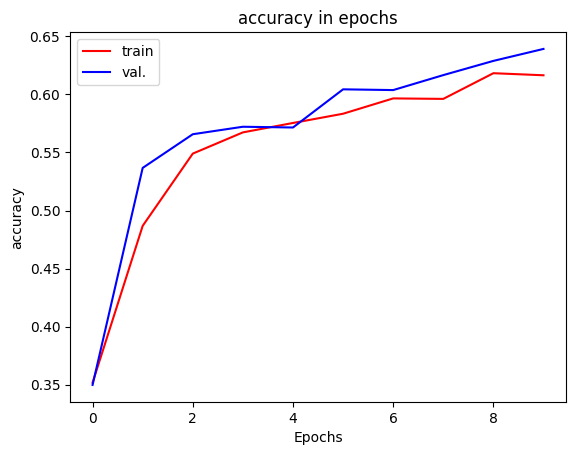

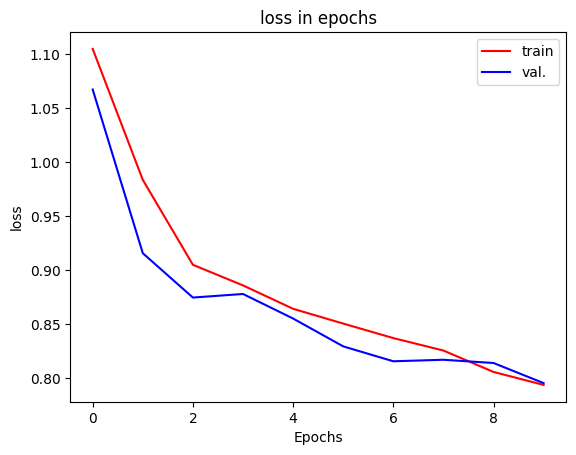

In [ ]:
plott(dict_s['train_acc'], dict_s['val_acc'], "accuracy in epochs", "accuracy", len(dict_s['val_acc']))
plott(dict_s['train_loss'], dict_s['val_loss'], "loss in epochs", "loss", len(dict_s['train_loss']))

In [ ]:
dict_s_test = runn(FarsTail_dataset, model, optimizer, criterion, epochs = 10, batch_size = 16, flag_test = True, flag_test_f = True, flag_val = False, flag_train = False)

F1_score: 0.6503
test_confusion_matrix:
 [[357 186  18]
 [111 214  84]
 [ 51 110 433]]
Test: Epoch 1, Loss: 0.7877, Accuracy: 0.6416
------------------------------------------------------------------------
F1_score: 0.6444
test_confusion_matrix:
 [[359 196  19]
 [118 198  81]
 [ 42 116 435]]
Test: Epoch 2, Loss: 0.7764, Accuracy: 0.6346
------------------------------------------------------------------------
F1_score: 0.6465
test_confusion_matrix:
 [[353 193  20]
 [122 209  79]
 [ 44 108 436]]
Test: Epoch 3, Loss: 0.7836, Accuracy: 0.6386
------------------------------------------------------------------------
F1_score: 0.6525
test_confusion_matrix:
 [[364 183  21]
 [117 210  81]
 [ 38 117 433]]
Test: Epoch 4, Loss: 0.7822, Accuracy: 0.6443
------------------------------------------------------------------------
F1_score: 0.6459
test_confusion_matrix:
 [[358 190  22]
 [116 200  77]
 [ 45 120 436]]
Test: Epoch 5, Loss: 0.7840, Accuracy: 0.6361
-------------------------------------------

## task3

In [ ]:
def delete_each_layer(layer_num):

  model = BERTNLIModel().to(device)

  del model.bert.encoder.layer[layer_num]

  for param in model.bert.parameters():
    param.requires_grad = False

  optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
  criterion = nn.CrossEntropyLoss().to(device)


  dict_s = runn(FarsTail_dataset, model, optimizer, criterion, epochs = 10, batch_size = 16,
                flag_test = False, flag_test_f = False, flag_val = False, flag_train = True)
  print("finish model training without layer :", layer_num)

  test_loss, test_acc, pred, labels = evaluate(model, test_loader, optimizer, criterion, flag_test_f = False)
  

  return test_acc



In [ ]:
for i in range(12):

  checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task3_layer" + str(i) +".pth.tar"
  path = F"/content/drive/My Drive/{checkpoint_name}" 

  test_acc_layer = delete_each_layer(i)
  
  checkpoint = {'test_acc_list' : test_acc_layer}
  save_checkpoint(checkpoint, filename= checkpoint_name)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.0944, Accuracy: 0.3648
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9735, Accuracy: 0.4986
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9128, Accuracy: 0.5408
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8967, Accuracy: 0.5496
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8861, Accuracy: 0.5587
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8713, Accuracy: 0.5707
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8610, Accuracy: 0.5728
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8446, Accuracy: 0.5821
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8379, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1056, Accuracy: 0.3466
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9853, Accuracy: 0.4900
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9149, Accuracy: 0.5490
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8847, Accuracy: 0.5596
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8739, Accuracy: 0.5684
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8578, Accuracy: 0.5743
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8507, Accuracy: 0.5805
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8415, Accuracy: 0.5860
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8232, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1089, Accuracy: 0.3379
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0876, Accuracy: 0.3716
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9964, Accuracy: 0.4804
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9516, Accuracy: 0.5125
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.9363, Accuracy: 0.5221
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.9243, Accuracy: 0.5298
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.9078, Accuracy: 0.5525
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8891, Accuracy: 0.5607
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8848, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1081, Accuracy: 0.3357
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0903, Accuracy: 0.3687
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9969, Accuracy: 0.4918
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9604, Accuracy: 0.5077
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.9339, Accuracy: 0.5357
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.9194, Accuracy: 0.5387
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.9145, Accuracy: 0.5460
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.9018, Accuracy: 0.5525
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.9028, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1067, Accuracy: 0.3401
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0235, Accuracy: 0.4576
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9468, Accuracy: 0.5276
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9158, Accuracy: 0.5412
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8894, Accuracy: 0.5647
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8876, Accuracy: 0.5635
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8648, Accuracy: 0.5809
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8571, Accuracy: 0.5849
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8461, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1033, Accuracy: 0.3567
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9593, Accuracy: 0.5135
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.8935, Accuracy: 0.5567
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8645, Accuracy: 0.5780
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8487, Accuracy: 0.5837
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8352, Accuracy: 0.5875
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8197, Accuracy: 0.6008
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8041, Accuracy: 0.6125
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.7863, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1064, Accuracy: 0.3402
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9937, Accuracy: 0.4837
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9108, Accuracy: 0.5475
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8868, Accuracy: 0.5532
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8629, Accuracy: 0.5685
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8478, Accuracy: 0.5788
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8339, Accuracy: 0.5912
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8297, Accuracy: 0.5973
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8106, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1057, Accuracy: 0.3391
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9951, Accuracy: 0.4848
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9217, Accuracy: 0.5438
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8913, Accuracy: 0.5602
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8779, Accuracy: 0.5606
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8511, Accuracy: 0.5797
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8505, Accuracy: 0.5852
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8368, Accuracy: 0.5889
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8224, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.0978, Accuracy: 0.3606
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9598, Accuracy: 0.5078
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9045, Accuracy: 0.5570
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8806, Accuracy: 0.5635
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8646, Accuracy: 0.5718
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8558, Accuracy: 0.5740
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8459, Accuracy: 0.5897
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8272, Accuracy: 0.6008
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8159, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1059, Accuracy: 0.3493
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0027, Accuracy: 0.4750
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9165, Accuracy: 0.5438
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8888, Accuracy: 0.5556
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8595, Accuracy: 0.5798
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8522, Accuracy: 0.5839
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8426, Accuracy: 0.5940
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8269, Accuracy: 0.6010
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.8183, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1019, Accuracy: 0.3578
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9449, Accuracy: 0.5196
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.8838, Accuracy: 0.5676
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8580, Accuracy: 0.5842
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8421, Accuracy: 0.5854
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8324, Accuracy: 0.5898
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8205, Accuracy: 0.5960
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.7989, Accuracy: 0.6140
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.7828, Accuracy: 

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1044, Accuracy: 0.3448
------------------------------------------------------------------------
Train: Epoch 2, Loss: 0.9672, Accuracy: 0.5058
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.8870, Accuracy: 0.5643
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.8683, Accuracy: 0.5732
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8543, Accuracy: 0.5823
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8438, Accuracy: 0.5865
------------------------------------------------------------------------
Train: Epoch 7, Loss: 0.8314, Accuracy: 0.5982
------------------------------------------------------------------------
Train: Epoch 8, Loss: 0.8149, Accuracy: 0.6032
------------------------------------------------------------------------
Train: Epoch 9, Loss: 0.7966, Accuracy: 

In [ ]:
acc_layers = []

for i in range(12):

  checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task3_layer" + str(i) +".pth.tar"
  path = F"/content/drive/My Drive/{checkpoint_name}" 
  acc_layers.append(load_checkpoint(torch.load(path),_))

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


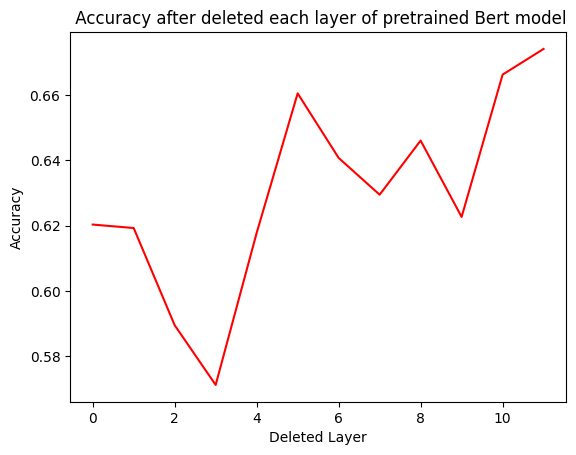

In [ ]:
plt.plot(range(0,len(acc_layers)), acc_layers, color='r')
plt.xlabel("Deleted Layer")
plt.ylabel("Accuracy")
plt.title(" Accuracy after deleted each layer of pretrained Bert model")
plt.show()

# task 4 transformers head

In [17]:
import torch.nn as nn

class BERTNLIModel_with_pruning(nn.Module):
    def __init__(self, dict_prune_layer):
        
        super().__init__()
        
        self.bert = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
        self.bert.prune_heads(dict_prune_layer)
        embedding_dim = self.bert.config.to_dict()['hidden_size']

        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(embedding_dim, 256)
        self.act_func = nn.ReLU()
        self.fc2 = nn.Linear(256, 3)

    def forward(self, sequence, attn_mask, token_type):
          
        embedded = self.bert(input_ids = sequence, attention_mask = attn_mask, token_type_ids= token_type)
        # print("embedded :",embedded)
        # print("embedded['last_hidden_state']:",embedded['last_hidden_state'])
        t_e = self.transformer_encoder( self.dropout(embedded['last_hidden_state']))
        out = self.act_func(self.fc1(torch.mean(t_e, dim=1)))
        out = self.fc2(out)

        return out

# deleted 50 percent of heads

In [18]:

def pick_heads(num):

  dict_prune_heads = {}

  for key in range(12):
      dict_prune_heads[key] = []

  for i in range(12):
    random_heads = [random.randint(0, 11) for _ in range(num)]
    dict_prune_heads[i] = random_heads


  return dict_prune_heads

In [ ]:
pick_heads(num = 6)

{0: [2, 9, 7, 8, 5, 6],
 1: [0, 8, 0, 6, 2, 3],
 2: [0, 1, 7, 3, 3, 7],
 3: [11, 6, 0, 11, 11, 1],
 4: [7, 4, 3, 1, 5, 11],
 5: [0, 3, 8, 5, 4, 0],
 6: [11, 3, 5, 11, 1, 11],
 7: [9, 11, 10, 3, 10, 8],
 8: [0, 2, 1, 1, 6, 3],
 9: [3, 4, 11, 7, 5, 9],
 10: [4, 9, 8, 0, 2, 4],
 11: [11, 7, 10, 5, 5, 8]}

In [ ]:
model = BERTNLIModel_with_pruning(pick_heads(num = 6)).to(device)
for param in model.bert.parameters():
  param.requires_grad = False

optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

dict_s = runn(FarsTail_dataset, model, optimizer, criterion, epochs = 5, batch_size = 16, flag_test = True, flag_test_f = False, flag_val = False, flag_train = True)
checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task4_50%.pth.tar"
checkpoint = {'test_acc_list' : dict_s}
save_checkpoint(checkpoint, filename= checkpoint_name)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1055, Accuracy: 0.3376
Test: Epoch 1, Loss: 1.1044, Accuracy: 0.3325
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0511, Accuracy: 0.4158
Test: Epoch 2, Loss: 0.9129, Accuracy: 0.5400
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9441, Accuracy: 0.5308
Test: Epoch 3, Loss: 0.8726, Accuracy: 0.5659
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9194, Accuracy: 0.5412
Test: Epoch 4, Loss: 0.8802, Accuracy: 0.5714
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.9131, Accuracy: 0.5438
Test: Epoch 5, Loss: 0.8902, Accuracy: 0.5759
------------------------------------------------------------------------
=> Saving checkpoint


# deleted 67 percent of heads

In [ ]:
model = BERTNLIModel_with_pruning(pick_heads(num = 7)).to(device)
for param in model.bert.parameters():
  param.requires_grad = False

optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

dict_s, test_loader = runn(FarsTail_dataset, model, optimizer, criterion, epochs = 5, batch_size = 16, flag_test = True, flag_test_f = False, flag_val = False, flag_train = True)
checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task4_70%.pth.tar"
checkpoint = {'test_acc_list' : dict_s}
save_checkpoint(checkpoint, filename= checkpoint_name)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1105, Accuracy: 0.3389
Test: Epoch 1, Loss: 1.0956, Accuracy: 0.3512
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0800, Accuracy: 0.3900
Test: Epoch 2, Loss: 0.9916, Accuracy: 0.4915
------------------------------------------------------------------------
Train: Epoch 3, Loss: 1.0110, Accuracy: 0.4728
Test: Epoch 3, Loss: 0.9819, Accuracy: 0.5000
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9805, Accuracy: 0.4973
Test: Epoch 4, Loss: 0.9363, Accuracy: 0.5383
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.9648, Accuracy: 0.5037
Test: Epoch 5, Loss: 0.9108, Accuracy: 0.5395
------------------------------------------------------------------------
=> Saving checkpoint


# deleted 83 percent of heads

In [22]:
model = BERTNLIModel_with_pruning(pick_heads(num = 8)).to(device)
for param in model.bert.parameters():
  param.requires_grad = False

optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

dict_s= runn(FarsTail_dataset, model, optimizer, criterion, epochs = 5, batch_size = 16, flag_test = True, flag_test_f = False, flag_val = False, flag_train = True)
checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task4_80%.pth.tar"
checkpoint = {'test_acc_list' : dict_s}
save_checkpoint(checkpoint, filename= checkpoint_name)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train: Epoch 1, Loss: 1.1090, Accuracy: 0.3374
Test: Epoch 1, Loss: 1.0954, Accuracy: 0.3673
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0908, Accuracy: 0.3688
Test: Epoch 2, Loss: 1.0390, Accuracy: 0.4554
------------------------------------------------------------------------
Train: Epoch 3, Loss: 1.0188, Accuracy: 0.4698
Test: Epoch 3, Loss: 0.9559, Accuracy: 0.5261
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9782, Accuracy: 0.4993
Test: Epoch 4, Loss: 0.9323, Accuracy: 0.5274
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.9518, Accuracy: 0.5162
Test: Epoch 5, Loss: 0.9130, Accuracy: 0.5504
------------------------------------------------------------------------
=> Saving checkpoint


# task 5


In [23]:
model = BERTNLIModel().to(device)

checkpoint_name = "my_checkpoint_tamrin4_nlp_q1_task2.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
load_checkpoint(torch.load(path),model)

optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


=> Loading checkpoint


In [45]:
test_df

,premise,hypothesis,label,hard(hypothesis),hard(overlap)
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,c,0,1
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,n,1,0
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,e,0,0
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,c,1,1
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,n,1,0
...,...,...,...,...,...
1559,دریای خَزَر یا دریای مازَندَران یا (با رواج کم...,در حاشیه ی دریای خزر کشور آذربایجان وجود ندارد.,c,0,1
1560,دریای خَزَر یا دریای مازَندَران یا (با رواج کم...,جمهوری آذربایجان به ترکی آذربایجانی بزرگترین ک...,n,0,1
1561,اولین چاپ مطالب به زبان فارسی در روزنامه‌های ه...,اولین روزنامه فارسی در هند انتشار یافت.,e,1,0
1562,اولین چاپ مطالب به زبان فارسی در روزنامه‌های ه...,ایران نخستین روزنامه فارسی را چاپ کرد.,c,1,0


In [44]:
test_df['hy'][0]

'دوران امامت امام صادق علیه السلام، مصادف است با ترجمه آثار یونانی و گسترش مبارزات فکری و ایدئولوژیکی و نیز ظهور مذاهب و مکتب های انحرافی.'

In [59]:
map_label = {'e': 0, 'c': 1, 'n': 2}
p = 155
premise = test_df['premise'][p]
hypothesis = test_df['hypothesis'][p]
label = map_label[test_df['label'][p]]
# Tokenize the premise and hypothesis using encode_plus
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased") # Using a pre-trained BERT tokenizer to encode sentences
encoded_input = tokenizer.encode_plus(
    text=premise,
    text_pair=hypothesis,
    add_special_tokens=True,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
sequence = encoded_input["input_ids"].to(device)
attn_mask = encoded_input["attention_mask"].to(device)
token_type = encoded_input["token_type_ids"].to(device)

predictions = model(sequence, attn_mask, token_type)
max_preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
correct = (max_preds==label).float()
predictions

tensor([[ 0.0922,  0.5773, -0.3096]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [48]:
max_preds

tensor([1], device='cuda:0')

In [33]:
predictions

tensor([[ 0.3960,  0.6263, -0.7072]], device='cuda:0',
       grad_fn=<AddmmBackward0>)